In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import warnings
from scipy.integrate import simpson

import astropy.units as u
import astropy.constants as const

In [2]:
plt.style.use('/Users/scully/Documents/mplstyles/paper.mplstyle')

In [3]:
# constants
G = const.G.cgs
c = const.c.cgs
M_sun = const.M_sun.cgs
L_sun = const.L_sun.cgs
m_e = const.m_e.cgs
m_u = const.u.cgs
h = const.h.cgs
k_B = const.k_B.cgs
R_sun = const.R_sun.cgs
mu_e = 1  # since we use X=1 in other parts of the question

a = 4 * const.sigma_sb.cgs / c
K = h**2 / (20 * m_e * (m_u)**(5/3)) * (3 / np.pi)**(2/3)
K = K.to(u.cm**4 / u.s**2 / u.g**(2/3))
kappa = 2 * 0.2 * u.cm**2 / u.g

In [4]:
def get_slopes(z, sols, n):
    slopes = np.zeros_like(sols)

    # Compute slopes using Lane-Emden equation
    slopes[0] = sols[1]
    slopes[1] = -2/z * sols[1] - sols[0]**n

    return slopes

def lane_emden(n, dz=1e-3, plot=False, z_max=20, method='RK4', z0=1e-6):
    u_0 = 1  # change of variables s.t. u = w
    v_0 = 0  # change of variables s.t. v = w'
    z_0 = z0  # initial z value to avoid division by zero
    w_0 = u_0

    ws = np.array([w_0])
    zs = np.array([z_0])

    sols = np.array([u_0, v_0])  # solution vector

    z = z_0

    while z <= z_max:
        if method=="euler":
            slopes = get_slopes(z, sols, n)
        elif method=="RK4":
            k1 = get_slopes(z, sols, n)
            k2 = get_slopes(z + dz/2, sols + k1*dz/2, n)
            k3 = get_slopes(z + dz/2, sols + k2*dz/2, n)
            k4 = get_slopes(z + dz, sols + k3*dz, n)
            slopes = (k1 + 2*k2 + 2*k3 + k4) / 6

        sols = sols + slopes * dz  # update solution vector
        z += dz

        zs = np.append(zs, z)
        ws = np.append(ws, sols[0])
    
    if plot:
        if method=="RK4":
            plt.plot(zs, ws, label=f"RK4, n={n}", linestyle='-')
        elif method=="euler":
            plt.plot(zs, ws, label=f"Euler, n={n}", linestyle='--')

    return zs, ws

In [5]:
n = 1.5
with warnings.catch_warnings(action="ignore"):
    zs, ws = lane_emden(n, dz=1e-3, plot=False, z_max=5, method='RK4', z0=1e-5)

# find last positive w value
last_positive_w = np.where(ws > 0)[0][-1]
zs = zs[:last_positive_w+1]
ws = ws[:last_positive_w+1]
print(zs[-1], ws[-1])

3.6530099999997088 0.00015123340794793945


In [6]:
ms_int = np.zeros_like(zs)
ps_int = np.zeros_like(zs)
ts_int = np.zeros_like(zs)
length_z = len(zs)

# get mass integrals
for i in range(len(zs)):
    ms_int[i] = simpson(zs[:i+1]**2 * ws[:i+1]**n, zs[:i+1])
    i = length_z - 1 - i
    ts_int[i] = simpson(zs[i:]**(-2) * ws[i:]**n, zs[i:])

# get pressure integral
ps_int = np.zeros_like(zs)
for i in range(len(zs)):
    ps_int[i] = simpson(zs[:i+1]**(-2) * ms_int[:i+1], zs[:i+1])

# get temperature intgerals starting at Z max
for i in range(len(zs)):
    i = length_z - 1 - i
    ts_int[i] = simpson(zs[i:]**(-2) * ws[i:]**n, zs[i:])

M_int = ms_int[-1]
rho_c = ((M_sun / (4 * np.pi * M_int)) * (8 * np.pi * G / (5 * K))**(3/2))**2
rho_c = rho_c.to(u.g / u.cm**3)
alpha = (5 * K * rho_c**(-1/3) / (8 * np.pi * G))**(1/2)

ms = 4 * np.pi * alpha**3 * rho_c * ms_int

# get density profile
rhos = rho_c * ws**n

# convert pressure integral to proper units
ps = 8 * np.pi / 5 * G * K**(-3/5) * mu_e * alpha**2 * rho_c * ps_int
P_c = ps[-1]**(5/2)  # matched K * rho_c ** (5/3) * mu_e

# apply central pressure 
Ps = (P_c**(2/5) - ps)**(5/2)
Ps = Ps.to(u.dyne / u.cm**2)

# convert temperature integral to proper units
Ts = (((3 * kappa * L_sun / (16 * np.pi * a * c)) * rho_c / alpha) * ts_int)**(1/4)
Ts = Ts.to(u.K)

rs = alpha * zs
rs = rs / R_sun

# get internal energy
E_int_int = simpson(zs**2 * ws**n * ts_int**(1/4), zs)
E_int = (6 * np.pi * k_B) / (m_u) * ((3 * kappa * L_sun) / (16 * np.pi * a * c))**(1/4) * alpha**(11/4) * rho_c**(5/4) * E_int_int
E_int = E_int.to(u.erg)

t_rad = E_int / L_sun
print(f"rho_c: {rho_c:.3e}")
print(f"P_c: {P_c.to(u.dyne / u.cm**2):.3e}")
print(f"E_int: {E_int:.3e}")
print(f"L_sun: {L_sun:.3e}")
print(f"t_rad: {t_rad.to(u.yr):.3e}")


rho_c: 1.270e+05 g / cm3
P_c: 3.218e+21 dyn / cm2
E_int: 1.093e+49 erg
L_sun: 3.828e+33 erg / s
t_rad: 9.050e+07 yr


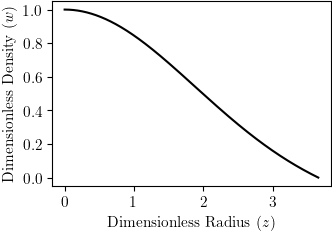

In [7]:
plt.plot(zs, ws, label="Lane-Emden Solution", color='black')
plt.ylabel(r"Dimensionless Density ($w$)")
plt.xlabel(r"Dimensionless Radius ($z$)")
plt.savefig("q3_w_profile.png", bbox_inches='tight', dpi=300)
plt.show()

<>:16: SyntaxWarning: invalid escape sequence '\o'
<>:23: SyntaxWarning: invalid escape sequence '\o'
<>:30: SyntaxWarning: invalid escape sequence '\o'
<>:16: SyntaxWarning: invalid escape sequence '\o'
<>:23: SyntaxWarning: invalid escape sequence '\o'
<>:30: SyntaxWarning: invalid escape sequence '\o'
/var/folders/6l/y2z2vm4913sb2lzhwp95z6q00000gn/T/ipykernel_23203/3723521765.py:16: SyntaxWarning: invalid escape sequence '\o'
  axs[1, 0].set_xlabel("R [R$_\odot$]")
/var/folders/6l/y2z2vm4913sb2lzhwp95z6q00000gn/T/ipykernel_23203/3723521765.py:23: SyntaxWarning: invalid escape sequence '\o'
  axs[1, 1].set_xlabel("R [R$_\odot$]")
/var/folders/6l/y2z2vm4913sb2lzhwp95z6q00000gn/T/ipykernel_23203/3723521765.py:30: SyntaxWarning: invalid escape sequence '\o'
  inset_ax.set_xlabel("R [R$_\odot$]", fontsize=8)
/var/folders/6l/y2z2vm4913sb2lzhwp95z6q00000gn/T/ipykernel_23203/3723521765.py:36: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might 

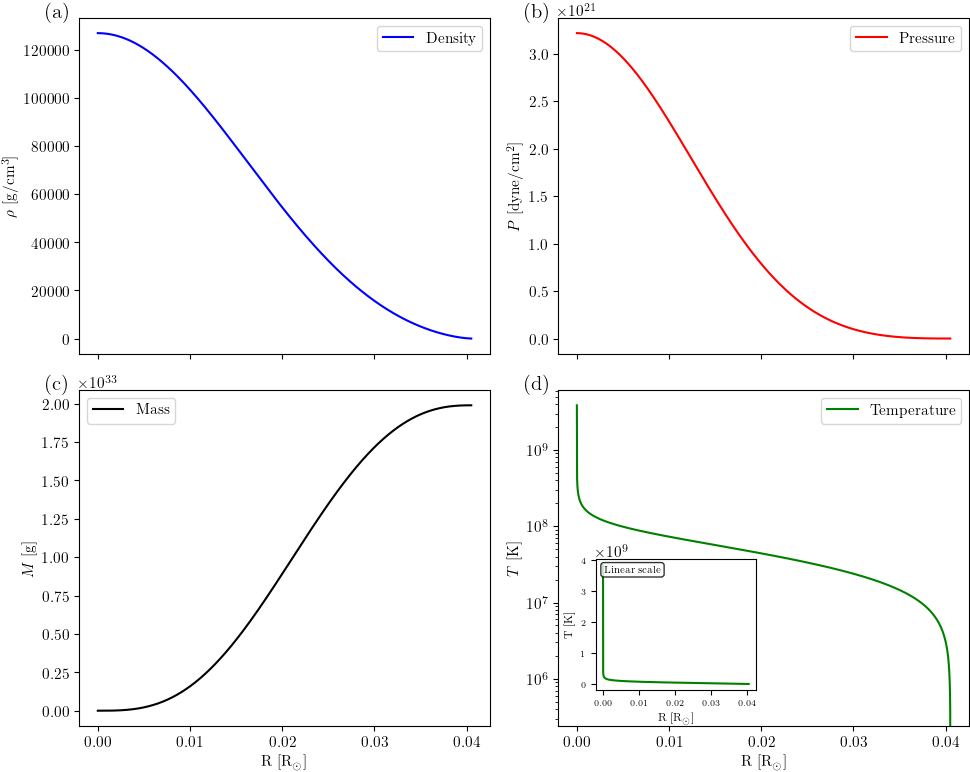

In [8]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8), sharex=True)

axs[0, 0].plot(rs, rhos, label="Density", color='blue')
axs[0, 0].set_ylabel(r"$\rho$ [g/cm$^3$]")
axs[0, 0].legend()
axs[0, 0].text(-0.08, 1.05, "(a)", transform=axs[0, 0].transAxes, fontsize=15, va='top')

axs[0, 1].plot(rs, Ps, label="Pressure", color='red')
axs[0, 1].set_ylabel(r"$P$ [dyne/cm$^2$]")
axs[0, 1].legend()
axs[0, 1].text(-0.08, 1.05, "(b)", transform=axs[0, 1].transAxes, fontsize=15, va='top')

axs[1, 0].plot(rs, ms, label="Mass", color='black')
axs[1, 0].set_ylabel(r"$M$ [g]")
axs[1, 0].legend()
axs[1, 0].set_xlabel("R [R$_\odot$]")
axs[1, 0].text(-0.08, 1.05, "(c)", transform=axs[1, 0].transAxes, fontsize=15, va='top')

axs[1, 1].plot(rs, Ts, label="Temperature", color='green')
axs[1, 1].set_ylabel(r"$T$ [K]")
axs[1, 1].set_yscale('log')
axs[1, 1].legend()
axs[1, 1].set_xlabel("R [R$_\odot$]")
axs[1, 1].text(-0.08, 1.05, "(d)", transform=axs[1, 1].transAxes, fontsize=15, va='top')

inset_ax = inset_axes(axs[1, 1], width="39%", height="39%", 
                      bbox_to_anchor=(-0.5, -0.48, 1, 1), bbox_transform=axs[1, 1].transAxes)

inset_ax.plot(rs, Ts, color='green', linewidth=1.5)
inset_ax.set_xlabel("R [R$_\odot$]", fontsize=8)
inset_ax.set_ylabel("T [K]", fontsize=8)
inset_ax.tick_params(labelsize=6)
inset_ax.text(0.05, 0.95, "Linear scale", transform=inset_ax.transAxes, fontsize=7, 
              verticalalignment='top', bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

plt.tight_layout()
plt.savefig("q3_star_profiles.png", bbox_inches='tight', dpi=300)
plt.show()